In [1]:
import numpy as np
import spreg
import libpysal
import bambi as bmb
import arviz as az
import pandas as pd
import geopandas
import numpy
from pysal.lib import weights
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pysal.lib import cg as geometry

from spreg import make_x, make_xb, dgp_lag


In [2]:
# Get points in a grid
n = 5
l = np.arange(n)
xs, ys = np.meshgrid(l, l)

rng = np.random.default_rng()
rho = .8

# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    polys.append(poly)
# Convert to GeoSeries
polys = geopandas.GeoSeries(polys)
gdf = geopandas.GeoDataFrame(
    {
        "geometry": polys,
        "id": ["P-%s" % str(i).zfill(2) for i in range(len(polys))],
    }
)
wr = weights.contiguity.Rook.from_dataframe(gdf)

u = make_x(rng,n**2,mu=[0],varu=[1], method='normal')

x = make_x(rng,n**2,mu=[0],varu=[1]) *2

xb = make_xb(x,[1,2])

wr.transform = "r"

y_d = dgp_lag(u, xb, wr,rho=rho)

gdf["y_d"] = y_d

gdf["xd"] = xb
gdf["w_d"] = weights.lag_spatial(wr,y_d)
gdf["time"] = 2
gdf2 =gdf.copy()

/tmp/ipykernel_4798/2421738931.py:23: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wr = weights.contiguity.Rook.from_dataframe(gdf)


In [3]:
# Get points in a grid
n = 5
l = np.arange(n)
xs, ys = np.meshgrid(l, l)

rng = np.random.default_rng()
rho = .8

# Set up store
polys = []
# Generate polygons
for x, y in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    polys.append(poly)
# Convert to GeoSeries
polys = geopandas.GeoSeries(polys)
gdf = geopandas.GeoDataFrame(
    {
        "geometry": polys,
        "id": ["P-%s" % str(i).zfill(2) for i in range(len(polys))],
    }
)
wr = weights.contiguity.Rook.from_dataframe(gdf)

u = make_x(rng,n**2,mu=[0],varu=[1], method='normal')

x = make_x(rng,n**2,mu=[0],varu=[1]) *2

xb = make_xb(x,[1,2]) *2

wr.transform = "r"

y_d = dgp_lag(u, xb, wr,rho=rho)

gdf["y_d"] = y_d

gdf["xd"] = xb
gdf["w_d"] = weights.lag_spatial(wr,y_d)
gdf["time"] = 1
gdf = pd.concat([gdf,gdf2])
gdf = gdf.reset_index(drop=True)
gdf

/tmp/ipykernel_4798/644727663.py:23: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wr = weights.contiguity.Rook.from_dataframe(gdf)


,geometry,id,y_d,xd,w_d,time
0,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))",P-00,75.041699,11.018901,80.409658,1
1,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))",P-01,77.822677,18.033718,73.442552,1
2,"POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))",P-02,82.161374,21.924430,75.858857,1
3,"POLYGON ((3 0, 4 0, 4 1, 3 1, 3 0))",P-03,70.790300,8.290079,78.393770,1
4,"POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))",P-04,84.941323,27.097333,73.206324,1
5,"POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))",P-05,82.996639,26.503982,69.743964,1
6,"POLYGON ((1 1, 2 1, 2 2, 1 2, 1 1))",P-06,63.124583,3.083365,75.534169,1
7,"POLYGON ((2 1, 3 1, 3 2, 2 2, 2 1))",P-07,78.963594,24.254595,70.027475,1
8,"POLYGON ((3 1, 4 1, 4 2, 3 2, 3 1))",P-08,68.078614,8.204028,75.264001,1
9,"POLYGON ((4 1, 5 1, 5 2, 4 2, 4 1))",P-09,75.622347,11.745417,80.392398,1


<Axes: >

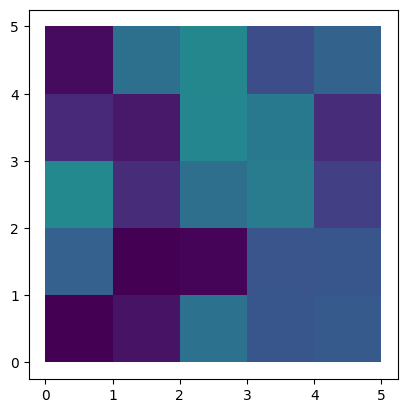

In [4]:
gdf.plot("xd")

In [5]:
pd.DataFrame(*wr.full()).astype(int)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_d = gdf["y_d"].values.reshape(-1,1)
xb = gdf["xd"].values.reshape(-1,1)

In [7]:
# weights.lag_spatial(wr,y_d)

In [8]:
# w  = libpysal.weights.lat2W(5, 5)
# wr = weights.contiguity.Rook.from_dataframe(gdf)
fe_lag = spreg.Panel_FE_Lag(y=y_d, x=xb, w=wr)
print(fe_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG PANEL - FIXED EFFECTS
-----------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:          50
Mean dependent var  :     -0.0000                Number of Variables   :           2
S.D. dependent var  :     17.6503                Degrees of Freedom    :          48
Pseudo R-squared    :      0.9988
Spatial Pseudo R-squared:  0.9972
Sigma-square ML     :       0.353                Log likelihood        :    -149.491
S.E of regression   :       0.594                Akaike info criterion :     302.981
                                                 Schwarz criterion     :     306.805

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------

In [9]:
# df = gdf.drop("geometry", axis=1)
# model = bmb.Model(
#     "y_d ~ xd + w_d",
#     df, dropna=True
# )
# results = model.fit()

In [10]:
# az.plot_trace(
#     results,
#     compact=True,
# )

In [11]:
# az.summary(results)